## Γιάννης Δαλιάνης 1115201700027
## Μιχαλης Φωτιάδης 1115201700183

# Ερώτημα 1

Imports

In [1]:
from __future__ import print_function

import pandas as pd

import os, glob

from pathlib import Path

import numpy as np

import matplotlib.pyplot as plt

from PIL import Image
from IPython.display import Image as ImShow

from wordcloud import WordCloud, STOPWORDS

import folium
from folium.plugins import MarkerCluster

from nltk import everygrams, word_tokenize
from nltk.collocations import BigramCollocationFinder
from nltk.collocations import *
from nltk.corpus import stopwords
from nltk.util import ngrams
import nltk, re, string, collections

import datetime

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

Δημιουργία train.csv αρχείου. 

In [2]:
pth = './Assets/data'

if os.path.exists("./train.csv"):
    train = pd.read_csv('./train.csv')
else :
    li = []
    cols = ['id', 'zipcode', 'transit', 'bedrooms', 'beds', 'review_scores_rating', 'number_of_reviews',
            'neighbourhood', 'name', 'latitude', 'longitude', 'last_review', 'instant_bookable', 'host_since',
            'host_response_rate', 'host_identity_verified', 'host_has_profile_pic', 'first_review', 'description',
            'city', 'cancellation_policy', 'bed_type', 'bathrooms', 'accommodates', 'amenities', 'room_type',
            'property_type', 'price','availability_365', 'minimum_nights']

    for path in Path(pth).rglob('*listings.csv'):
        df = pd.read_csv(path, usecols=cols)
        li.append(df)
        df.reset_index(drop=True, inplace = True)

    train = pd.concat(li).drop_duplicates()
    train.to_csv('train.csv')

train = train.loc[:, ~train.columns.str.contains('^Unnamed')]
train = train.fillna('')
train.drop_duplicates(subset=["id"], keep="first", inplace = True)

train.head()

id                                 name  \
0  10595  96m2, 3BR, 2BA, Metro, WI-FI etc...   
1  10988   75m2, 2-br, metro, wi-fi, cable TV   
2  10990    50m2, Metro, WI-FI, cableTV, more   
3  10993  Studio, metro, cable tv, wi-fi, etc   
4  10995  47m2, close to metro,cable TV,wi-fi   

                                         description  \
0  Athens Furnished Apartment No6 is 3-bedroom ap...   
1  Athens Furnished Apartment No4 is 2-bedroom ap...   
2  Athens Furnished Apartment No3 is 1-bedroom ap...   
3  The Studio is an  -excellent located  -close t...   
4  AQA No2 is 1-bedroom apartment (47m2)  -excell...   

                                             transit  host_since  \
0  Note: 5-day ticket for all the public transpor...  2009-09-08   
1  Note: 5-day ticket for all the public transpor...  2009-09-08   
2  Note: 5-day ticket for all the public transpor...  2009-09-08   
3  Note: 5-day ticket for all the public transpor...  2009-09-08   
4  Note: 5-day ticket for all the public transpor...  2009-09-08   

  host_response_rate host_has_profile_pic host_identity_verified  \
0               100%                    t                      t   
1               100%                    t                      t   
2               100%                    t                      t   
3               100%                    t                      t   
4               100%                    t                      t   

  neighbourhood    city  ...  \
0    Ambelokipi  Athens  ...   
1    Ambelokipi  Athens  ...   
2    Ambelokipi  Athens  ...   
3    Ambelokipi  Athens  ...   
4    Ambelokipi  Athens  ...   

                                           amenities   price  minimum_nights  \
0  {TV,"Cable TV",Internet,Wifi,"Air conditioning...  $73.00               1   
1  {TV,"Cable TV",Internet,Wifi,"Air conditioning...  $82.00               1   
2  {TV,"Cable TV",Internet,Wifi,"Air conditioning...  $49.00               1   
3  {TV,"Cable TV",Internet,Wifi,"Air conditioning...  $38.00               1   
4  {TV,"Cable TV",Internet,Wifi,"Air conditioning...  $49.00               2   

  availability_365 number_of_reviews  first_review  last_review  \
0              222                19    2011-05-20   2019-04-08   
1                0                31    2012-10-21   2017-11-23   
2              234                29    2012-09-06   2019-03-03   
3              226                45    2012-09-24   2019-04-04   
4              249                17    2010-07-08   2019-04-04   

  review_scores_rating instant_bookable          cancellation_policy  
0                   97                t  strict_14_with_grace_period  
1                   92                t  strict_14_with_grace_period  
2                   97                t  strict_14_with_grace_period  
3                   96                t  strict_14_with_grace_period  
4                   95                t  strict_14_with_grace_period  

[5 rows x 30 columns]

## 1.1

Συχνότητα κάθε τύπου δωματίου.

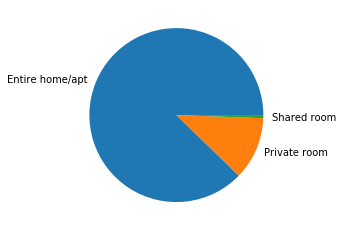

In [3]:
_ = train['room_type'].value_counts().plot(kind='pie', label='')

## 1.2

Οι μεταβολές στη μέση τιμή των τιμών διαμερισμάτων τον Φεβρουάριο, τον Μάρτιο και τον Απρίλιο του 2019.

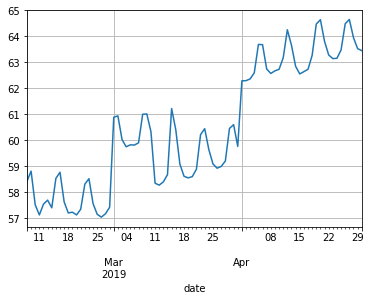

In [4]:
li = []
for path in Path(pth).rglob('*calendar.csv'):
        df12 = pd.read_csv(path)
        li.append(df12)

df12 = pd.concat(li).reset_index(drop=True)

df12['date']= pd.to_datetime(df12['date'])
df12 = df12[ (df12['date'].dt.year.astype(int) == 2019) & (df12['date'].dt.month.astype(int).isin([2, 3, 4])) ]

df12 = df12.dropna(subset=['price'])
df12['price'] = df12['price'].replace('[\$\,]', '', regex=True).astype(float)
df12.sort_values('date')
df12.set_index('date', inplace=True)

_ = df12['price'].groupby(df12.index).mean().plot(grid=True, x='date', y='price')

plt.show()

## 1.3

Οι πέντε γειτονιές με τις περισσότερες κριτικές.

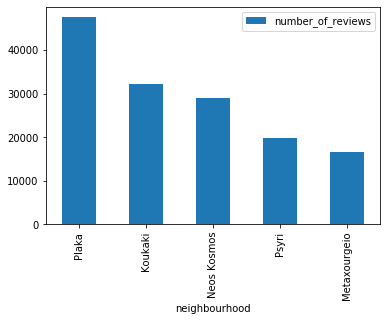

In [5]:
# try
df13 = train[['neighbourhood', 'number_of_reviews']]
df13 = df13.groupby(["neighbourhood"]).sum()
df13 = df13.sort_values(['number_of_reviews'], ascending=False)
_ = df13.iloc[0:5].plot(y='number_of_reviews', kind='bar')

## 1.4

Η γειτονιά με τις περισσότερες καταχωρήσεις ακινήτων.

In [6]:
train['neighbourhood'].value_counts().head(1)

Plaka    1169
Name: neighbourhood, dtype: int64

Οι πέντε γειτονιές με τις περισσότερες καταχωρήσεις ακινήτων.

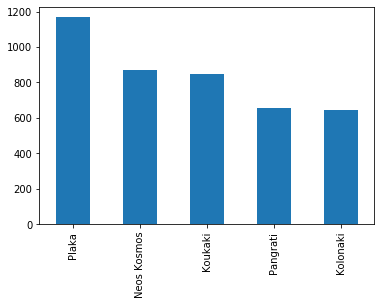

In [7]:
_ = train['neighbourhood'].value_counts().head(5).plot(kind='bar')    # first 5

## 1.5

Καταχωρήσεις ανά γειτονιά τους μήνες Φεβρουάριο, Μάρτιο, Απρίλιο

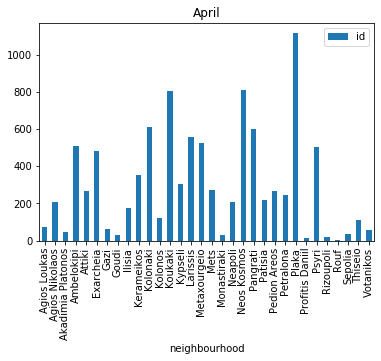

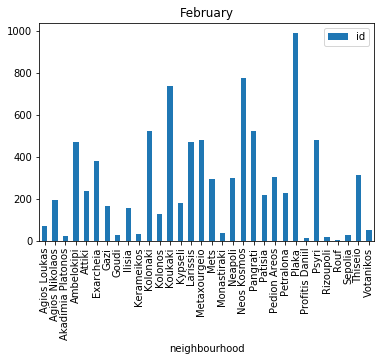

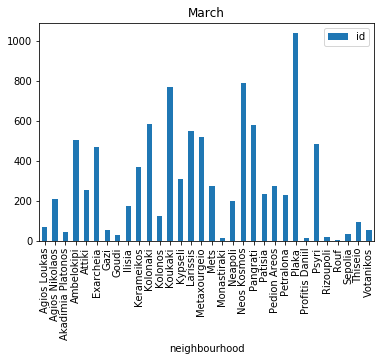

In [8]:
for path in Path(pth).rglob('*listings.csv'):
        df15 = pd.read_csv(path, usecols=['id', 'neighbourhood'])
        df15.set_index('neighbourhood', inplace=True)
        
        title = path
        title = title.__str__()
        title = title.replace("\\", " ").split()
        if title[2] == 'febrouary':
            title[2] = 'february'
        
        df15.groupby(['neighbourhood']).count().plot(kind='bar', title=title[2].capitalize())

## 1.6

Ιστόγραμμα της μεταβλητής neighborhood.

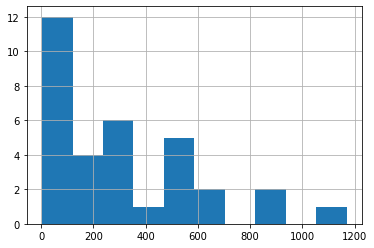

In [9]:
df16 = train[['neighbourhood']]
df16 = df16.dropna(subset=['neighbourhood'])
_ = df16['neighbourhood'].value_counts().hist()

## 1.7

Συχνότητα κάθε τύπου δωματίου ανά γειτονιά. Οι γειτονιές είναι 32 και το πρώτο plot πρέπει να είναι κενό.

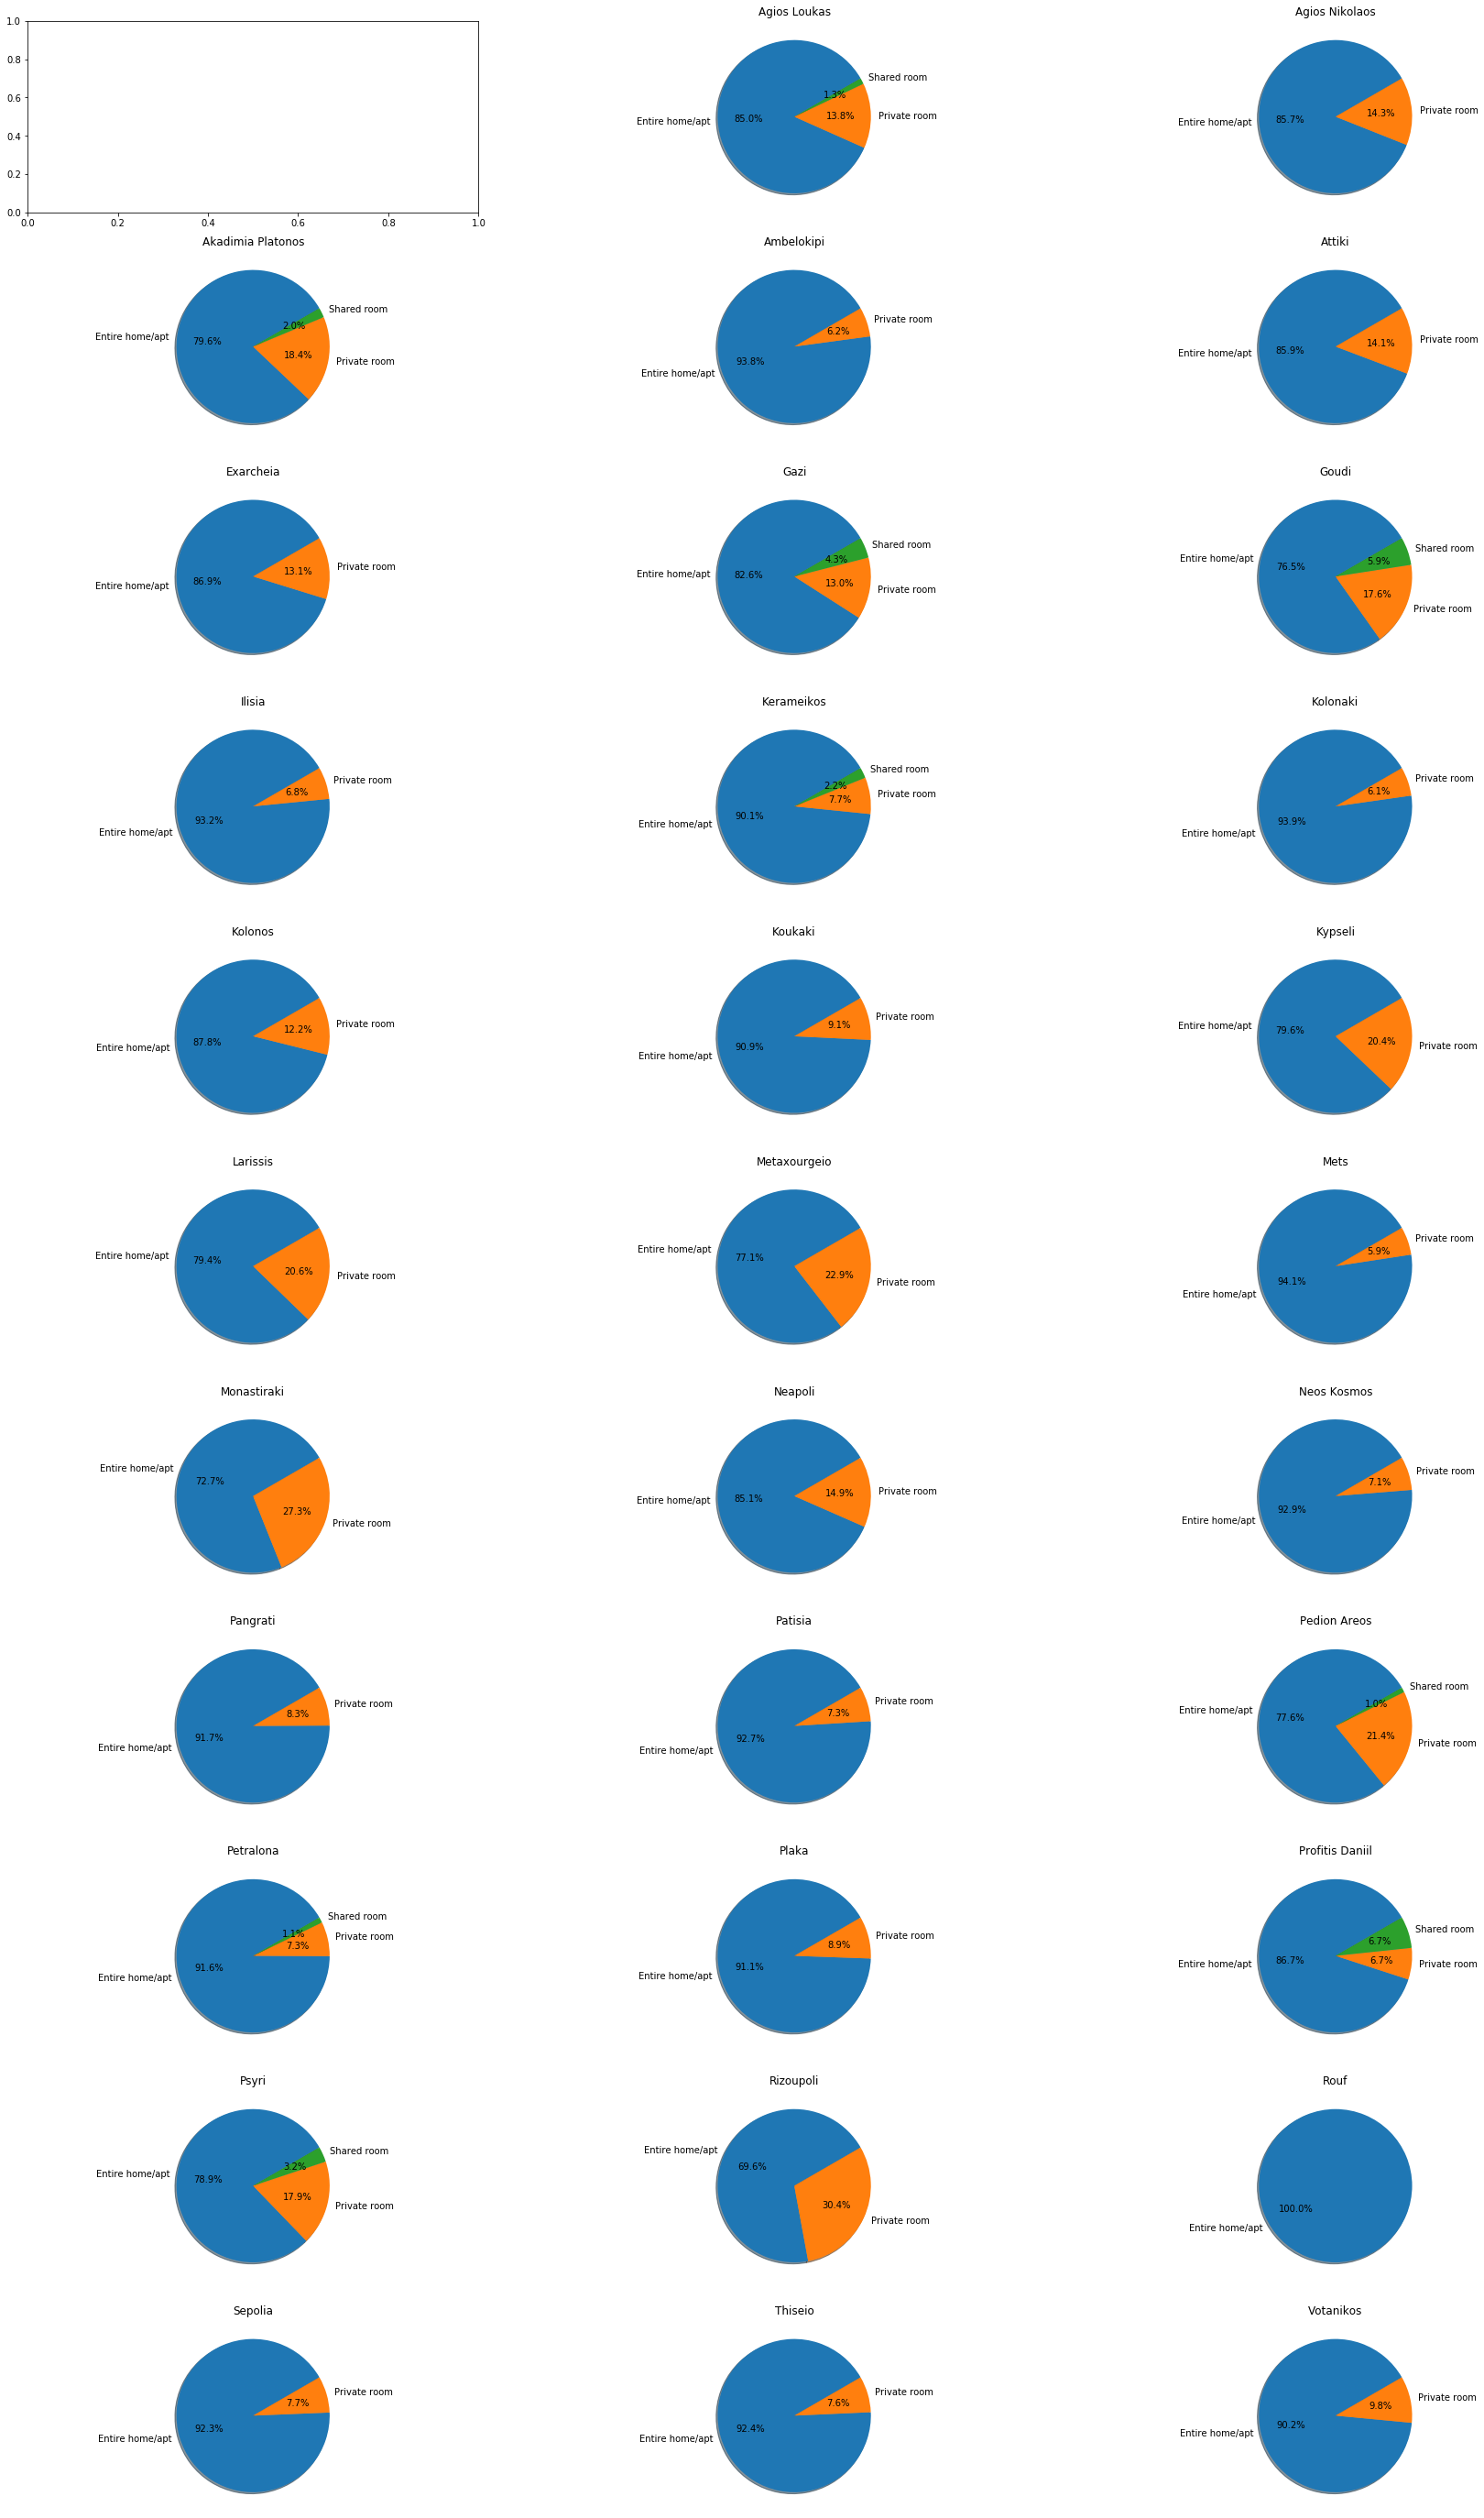

In [10]:
df17 = train[['neighbourhood','room_type']]

total = len(df17['neighbourhood'].unique()[:-1])

df_g = df17.groupby(['neighbourhood']).room_type.value_counts()
df17b = df_g.unstack()

fig, axes = plt.subplots( int(total/3)+1, 3, figsize=(30, 50))

for i, (idx, row) in enumerate(df17b.iterrows()):
    if i!=0:
        ax = axes[i // 3, i % 3]
        row = row[row.gt(row.sum() * .01)]
        ax.pie(row, labels=row.index, startangle=30, autopct='%1.1f%%', shadow=True)
        ax.set_title(idx)

## 1.8

Η μέση τιμή κάθε τύπου δωματίου.

In [11]:
train['price'] = train['price'].replace('[\$\,]', '', regex=True).astype(float)
for r_type in train['room_type'].unique():
    print(r_type, train.loc[train['room_type'] == r_type]['price'].mean())

Entire home/apt 63.485842844600526
Private room 74.71828665568368
Shared room 30.610169491525422


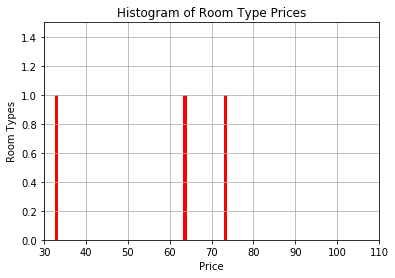

In [12]:
train['price'] = train['price'].replace('[\$\,]', '', regex=True).astype(float)
maxes = train[['price','room_type']].groupby('room_type').mean()#.head()

n, bins, patches = plt.hist(maxes, 15, density=False, facecolor='r', alpha=1)

plt.xlabel('Price')
plt.ylabel('Room Types')
plt.title('Histogram of Room Type Prices')
plt.xlim(30, 110)
plt.ylim(0, 1.5)
plt.grid(True)
plt.show()

## 1.9

Folium map 500 διαμερισμάτων.

In [13]:
locations = train[['latitude', 'longitude']]
locations = locations[0:500]
locationlist = locations.values.tolist()

map = folium.Map(location=[37.9838, 23.7275], zoom_start=12)

marker_cluster = MarkerCluster().add_to(map)

for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=train['room_type'][point], icon=folium.Icon(color='darkblue', icon_color='white', icon='hotel', angle=0, prefix='fa')).add_to(marker_cluster)
map

Screenshot του folium map.

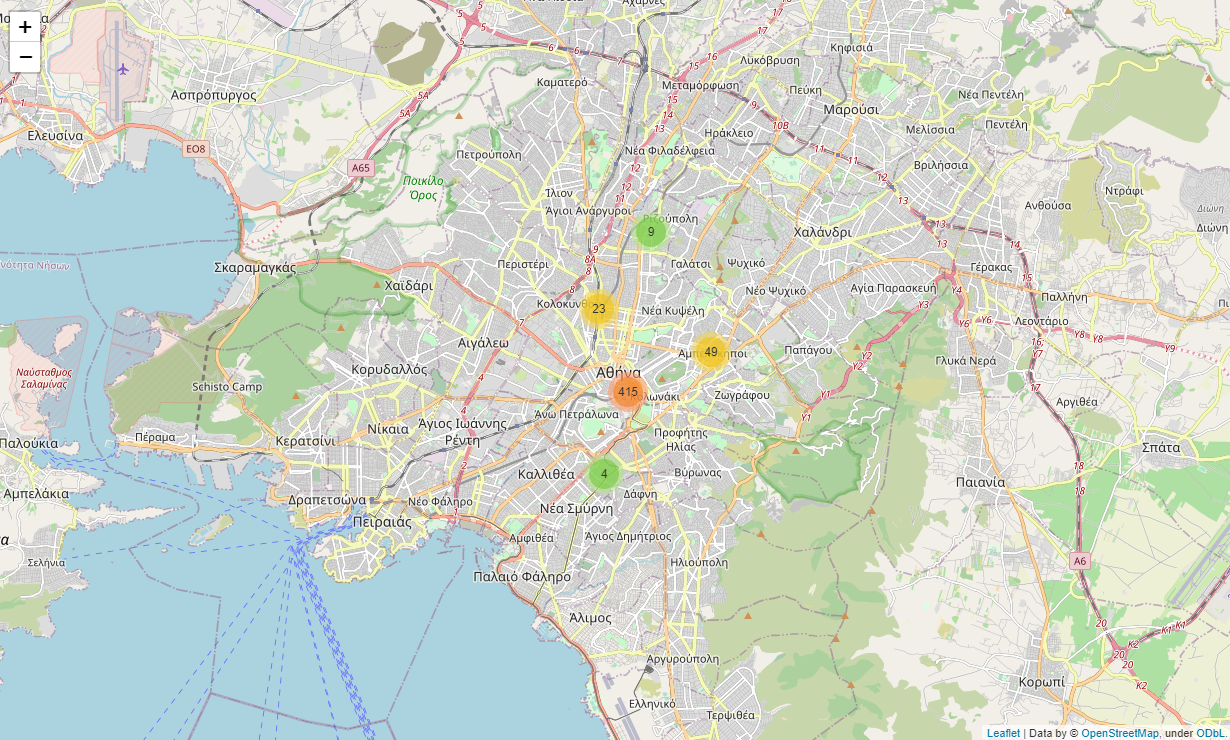

In [14]:
ImShow("./my_map.png")

Screenshot ενός popup.

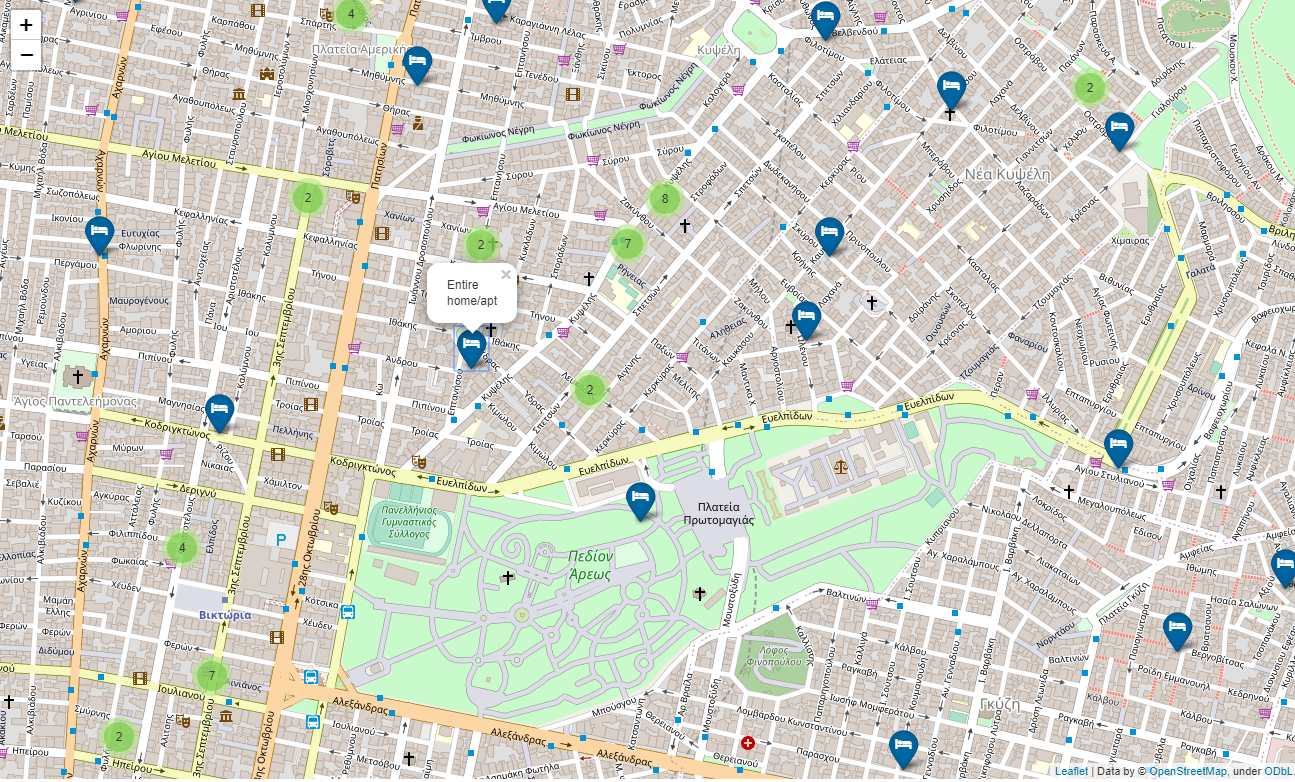

In [15]:
ImShow("./pop_up.png")

## 1.10

Wordclouds των τεσσάρων στηλών.

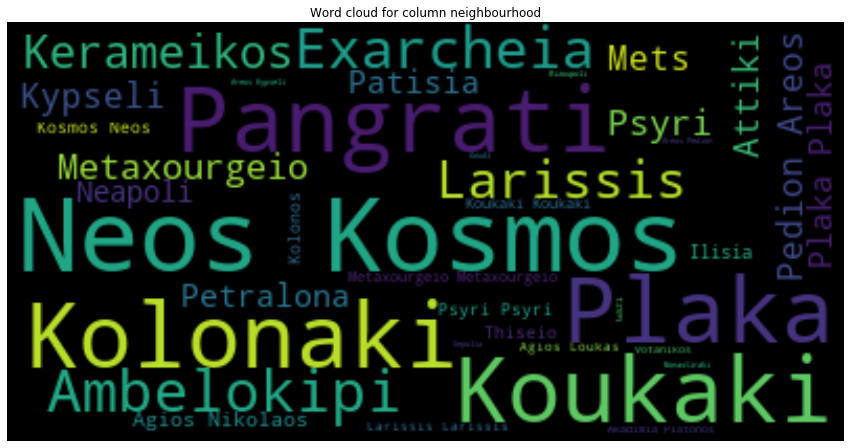

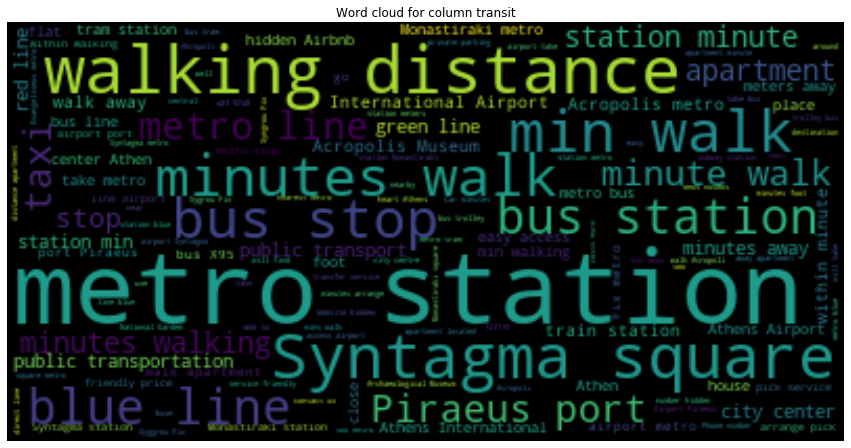

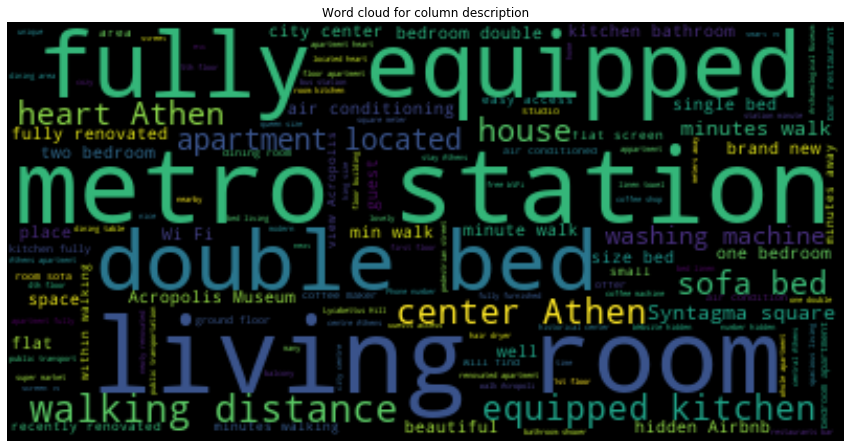

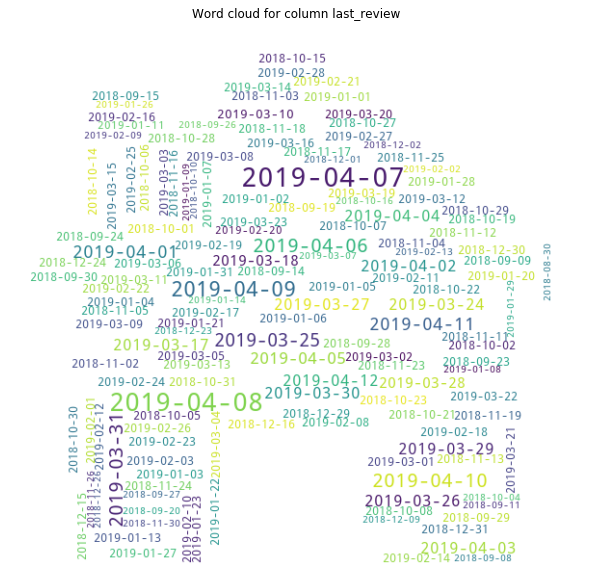

In [16]:
comment_words = ' '
stopwords = set(STOPWORDS)
stopwords.update(['nan',' ',''])

fields = ['neighbourhood', 'transit', 'description', 'last_review']

train["last_review"] = train["last_review"].fillna('')
train.last_review = train.last_review.astype(str)

df110 = train[fields]

house_mask = np.array(Image.open("./mask_house.png"))

fields = ['neighbourhood', 'transit', 'description']
for field in fields:
    text = df110[field].astype(str)   
    
    wordcloud = WordCloud(max_font_size=50, max_words=150).generate(' '.join(text))
    
    plt.figure(figsize=[15,10])
    plt.title('Word cloud for column ' + str(field))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()


counts = df110['last_review'].value_counts()
counts.index = counts.index.map(str)

wordcloud = WordCloud(background_color="white", max_font_size=50, max_words=150, mask=house_mask).generate_from_frequencies(counts)

plt.figure(figsize=[15,10])
plt.title('Word cloud for column ' + str('last_review'))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## 1.11

Μέση Τιμή του Entire home/apt ανά γειτονιά.

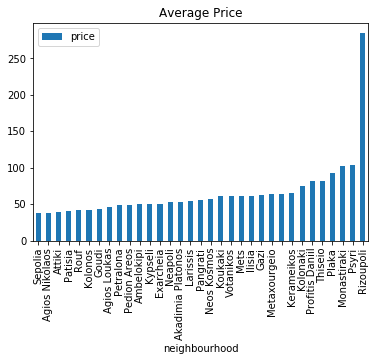

In [17]:
df111 = train[['neighbourhood','room_type', 'price']]
_ = df111.loc[train['room_type'] == 'Entire home/apt'].groupby(['neighbourhood']).mean().sort_values(['price'], ascending=True).plot(kind='bar', title='Average Price')

Οι 5 γειτονιές με τη χαμηλότερη average τιμή στο host response rate.

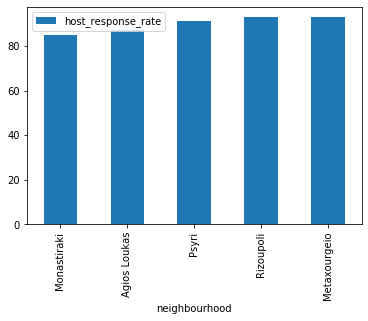

In [18]:
df111b = train[['neighbourhood','host_response_rate']]

df111b = df111b.replace(r'^\s*$', np.NaN, regex=True)

df111b = df111b.dropna(subset=['host_response_rate'])
df111b['host_response_rate'] = df111b['host_response_rate'].replace('[\%]', '', regex=True).astype(float)
_ = df111b.groupby('neighbourhood').mean().sort_values(['host_response_rate'], ascending=True).head(5).plot(kind='bar')

# Ερώτημα 2

Wordcloud χρησιμοποιώντας διάφορες παραμέτρους για τη στήλη description.

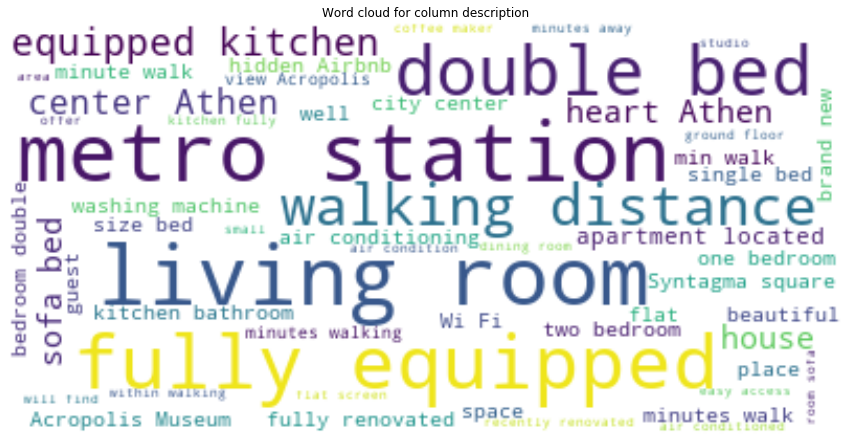

In [19]:
train = train[['id', 'name', 'description']]

text = train['description'].astype(str)   

wordcloud = WordCloud(background_color="white", max_font_size=40, max_words=120, mode="RGBA", font_path=None, width=400, height=200, margin=2, min_font_size=4, font_step=2).generate(' '.join(text))

plt.figure(figsize=[15,10])
plt.title('Word cloud for column ' + str(field))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Concatenation των στηλών name και description.

In [20]:
df21 = train
df21['description'] = df21['description'].fillna("")
df21['name'] = df21['name'].fillna("")

df21['New_col'] = df21[['name', 'description']].astype(str).agg(' '.join, axis=1)

df21['New_col'] = df21['New_col'].fillna('')

df21.head()

id                                 name  \
0  10595  96m2, 3BR, 2BA, Metro, WI-FI etc...   
1  10988   75m2, 2-br, metro, wi-fi, cable TV   
2  10990    50m2, Metro, WI-FI, cableTV, more   
3  10993  Studio, metro, cable tv, wi-fi, etc   
4  10995  47m2, close to metro,cable TV,wi-fi   

                                         description  \
0  Athens Furnished Apartment No6 is 3-bedroom ap...   
1  Athens Furnished Apartment No4 is 2-bedroom ap...   
2  Athens Furnished Apartment No3 is 1-bedroom ap...   
3  The Studio is an  -excellent located  -close t...   
4  AQA No2 is 1-bedroom apartment (47m2)  -excell...   

                                             New_col  
0  96m2, 3BR, 2BA, Metro, WI-FI etc... Athens Fur...  
1  75m2, 2-br, metro, wi-fi, cable TV Athens Furn...  
2  50m2, Metro, WI-FI, cableTV, more Athens Furni...  
3  Studio, metro, cable tv, wi-fi, etc The Studio...  
4  47m2, close to metro,cable TV,wi-fi AQA No2 is...

## 2.1

TFIDF column με την TFIDF value για κάθε New_col.

In [21]:
from sklearn.feature_extraction import text

df21a = df21

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

my_stop_words = text.ENGLISH_STOP_WORDS.union(["my","και", "με", "το"])

v = TfidfVectorizer(ngram_range=(1,2), stop_words=my_stop_words)
x = v.fit_transform(df21a.New_col)

df21a['TFIDF'] = list(x)
df21a.head()

# idf_values = dict(zip(v.get_feature_names(), v.idf_))
# n_items = take(50, idf_values.items())
# n_items

# printing the vocabulary
# print(v.vocabulary_)

id                                 name  \
0  10595  96m2, 3BR, 2BA, Metro, WI-FI etc...   
1  10988   75m2, 2-br, metro, wi-fi, cable TV   
2  10990    50m2, Metro, WI-FI, cableTV, more   
3  10993  Studio, metro, cable tv, wi-fi, etc   
4  10995  47m2, close to metro,cable TV,wi-fi   

                                         description  \
0  Athens Furnished Apartment No6 is 3-bedroom ap...   
1  Athens Furnished Apartment No4 is 2-bedroom ap...   
2  Athens Furnished Apartment No3 is 1-bedroom ap...   
3  The Studio is an  -excellent located  -close t...   
4  AQA No2 is 1-bedroom apartment (47m2)  -excell...   

                                             New_col  \
0  96m2, 3BR, 2BA, Metro, WI-FI etc... Athens Fur...   
1  75m2, 2-br, metro, wi-fi, cable TV Athens Furn...   
2  50m2, Metro, WI-FI, cableTV, more Athens Furni...   
3  Studio, metro, cable tv, wi-fi, etc The Studio...   
4  47m2, close to metro,cable TV,wi-fi AQA No2 is...   

                                               TFIDF  
0    (0, 103900)\t0.08214511742136285\n  (0, 1763...  
1    (0, 59603)\t0.0852689529533397\n  (0, 44817)...  
2    (0, 155922)\t0.09515757937195933\n  (0, 1865...  
3    (0, 212260)\t0.08905961080596157\n  (0, 5639...  
4    (0, 187320)\t0.08558916043398722\n  (0, 5146...

Δεύτερος Τρόπος: Tokens TfidfVectorizer

In [22]:
dfgg = df21[0:20]

# Create the Document Term Matrix
# count_vectorizer = CountVectorizer(stop_words='english')
count_vectorizer = TfidfVectorizer(stop_words='english')

sparse_matrix = count_vectorizer.fit_transform(dfgg.New_col)

col_id_list = dfgg['id'].tolist()

# # OPTIONAL: Convert Sparse Matrix to Pandas Dataframe if you want to see the word frequencies.
doc_term_matrix = sparse_matrix.todense()
df90 = pd.DataFrame(doc_term_matrix, 
                  columns=count_vectorizer.get_feature_names(), 
                  index=col_id_list
                 )

df90.head()

00   05   10  100  100m²   15       1st  2009  200sqm  2013  ...  \
10595  0.0  0.0  0.0  0.0    0.0  0.0  0.111369   0.0     0.0   0.0  ...   
10988  0.0  0.0  0.0  0.0    0.0  0.0  0.000000   0.0     0.0   0.0  ...   
10990  0.0  0.0  0.0  0.0    0.0  0.0  0.000000   0.0     0.0   0.0  ...   
10993  0.0  0.0  0.0  0.0    0.0  0.0  0.000000   0.0     0.0   0.0  ...   
10995  0.0  0.0  0.0  0.0    0.0  0.0  0.000000   0.0     0.0   0.0  ...   

       wish  wonderful  working  works  world     worry  www  xbox360  york  \
10595   0.0        0.0      0.0    0.0    0.0  0.111369  0.0      0.0   0.0   
10988   0.0        0.0      0.0    0.0    0.0  0.000000  0.0      0.0   0.0   
10990   0.0        0.0      0.0    0.0    0.0  0.000000  0.0      0.0   0.0   
10993   0.0        0.0      0.0    0.0    0.0  0.000000  0.0      0.0   0.0   
10995   0.0        0.0      0.0    0.0    0.0  0.000000  0.0      0.0   0.0   

       zappeion  
10595       0.0  
10988       0.0  
10990       0.0  
10993       0.0  
10995       0.0  

[5 rows x 739 columns]

## 2.2

In [23]:
my_df = df21a[["name", "id", "description", "New_col", "TFIDF"]][0:20]

Πρώτος τρόπος για υπολογισμό πίνακα cosine similarity για κάθε ζευγάρι ακινήτων χρησιμοποιώντας τις TFIDF τιμές που έχουμε βρει. Τα cosine similarity για τα ζευγάρια ίδιων ακινήτων γίνονται 0. Απελπιστικά πολύ αργός.

In [24]:
# TFIDF_only = df21[["id", "TFIDF"]].set_index("id")
# # TFIDF_only.head()

# col_id_list = my_df['id'].tolist()

# df91 = pd.DataFrame(
#                     0.,
#                     index=col_id_list,
#                     columns=col_id_list
#                 )

# for R in col_id_list:
#     for C in col_id_list:
#         df91[C][R] = df91[C][R] + cosine_similarity(TFIDF_only["TFIDF"][C], TFIDF_only["TFIDF"][R])

# np.fill_diagonal(df91.values, 0.)
# df91.head()

Δεύτερος τρόπος για υπολογισμό πίνακα cosine similarity από το dataframe των Tokens TfidfVectorizer. Τα cosine similarity για τα ζευγάρια ίδιων ακινήτων γίνονται 0.

In [25]:
df91 = pd.DataFrame(cosine_similarity(df90, df90), 
                  columns=col_id_list, 
                  index=col_id_list)
df91 = df91.astype(float)
np.fill_diagonal(df91.values, 0)
df91.head()

10595     10988     10990     10993     10995     27262     28186  \
10595  0.000000  0.595815  0.648491  0.437089  0.639422  0.209737  0.033679   
10988  0.595815  0.000000  0.687800  0.621457  0.672711  0.256496  0.033328   
10990  0.648491  0.687800  0.000000  0.544436  0.762077  0.218418  0.039874   
10993  0.437089  0.621457  0.544436  0.000000  0.643877  0.168182  0.032646   
10995  0.639422  0.672711  0.762077  0.643877  0.000000  0.200286  0.018607   

          31155     33704     38100     40149     44858     48635     49489  \
10595  0.037348  0.092729  0.081318  0.147349  0.154200  0.123983  0.213454   
10988  0.029692  0.107206  0.078046  0.127366  0.135404  0.090423  0.156068   
10990  0.041838  0.115523  0.102288  0.143757  0.151183  0.102271  0.153961   
10993  0.029740  0.160457  0.044311  0.044623  0.082557  0.056749  0.049559   
10995  0.040455  0.110785  0.084200  0.107719  0.136178  0.094764  0.115261   

          54637     59663     60394     68425     79423     80598  
10595  0.078012  0.136447  0.087867  0.083085  0.065090  0.120522  
10988  0.083040  0.111486  0.078788  0.110950  0.064969  0.113446  
10990  0.094130  0.147614  0.114250  0.087802  0.068093  0.112826  
10993  0.066630  0.098764  0.024102  0.079144  0.052630  0.078002  
10995  0.094162  0.131256  0.042489  0.092778  0.059990  0.105031

Συνάρτηση που επιστρέφει τις θέσεις του στοιχείου value σε ένα dataframe.

In [26]:
def getIndexes(dfObj, value):
    ''' Get index positions of value in dataframe i.e. dfObj.'''
    
    listOfPos = list()
    
    # Get bool dataframe with True at positions where the given value exists
    result = dfObj.isin([value])
    
    # Get list of columns that contains the value
    seriesObj = result.any()
    columnNames = list(seriesObj[seriesObj == True].index)
    
    # Iterate over list of columns and fetch the rows indexes where value exists
    for col in columnNames:
        rows = list(result[col][result[col] == True].index)
        for row in rows:
            listOfPos.append((row, col))
    # Return a list of tuples indicating the positions of value in the dataframe
    return listOfPos

Συνάρτηση που επιστρέφει το dictionary με τα 100 πιο παρόμοια ζεύγη ακινήτων στη μορφή {<θέση από 0 έως 99> [cosine similarity, (id1, id2)]}.

In [27]:
def createDic(df):
    Nlargest = df91.stack().nlargest(3000).tolist()
    Nlargest.sort(reverse=True)
    listRet = list()
    
    found = 0
    counter = 0
    while found<100 and counter<len(Nlargest):
        listOfPositions = getIndexes(df, Nlargest[counter])
        if [Nlargest[counter], listOfPositions[0]] not in listRet:
            listRet.append([Nlargest[counter], listOfPositions[0]])
            found+=1
        counter+=1

    listRet = listRet[0:100]
    listRet = { i : listRet[i] for i in range(0, len(listRet) ) }
    return listRet

In [28]:
my_dict = createDic(df91)

for key, value in sorted(my_dict.items()):
    print(key, value)

0 [0.7620766408588547, (10995, 10990)]
1 [0.6878003454334886, (10990, 10988)]
2 [0.672711268648561, (10995, 10988)]
3 [0.648491125618516, (10990, 10595)]
4 [0.6438767042921334, (10995, 10993)]
5 [0.6394223775159794, (10995, 10595)]
6 [0.6214565946263222, (10993, 10988)]
7 [0.5958152980115504, (10988, 10595)]
8 [0.544436358088205, (10993, 10990)]
9 [0.4370894244295831, (10993, 10595)]
10 [0.2564958229984355, (27262, 10988)]
11 [0.22704525829146138, (40149, 79423)]
12 [0.22704525829146135, (79423, 40149)]
13 [0.21841782863407685, (27262, 10990)]
14 [0.21345433958218543, (49489, 10595)]
15 [0.2102281742736349, (79423, 60394)]
16 [0.2097370257221902, (27262, 10595)]
17 [0.2002858505245798, (27262, 10995)]
18 [0.18855516841016234, (49489, 40149)]
19 [0.18532719717030008, (49489, 27262)]
20 [0.16818185433254004, (27262, 10993)]
21 [0.1676794466801153, (60394, 40149)]
22 [0.16177834059112794, (44858, 40149)]
23 [0.16045654788340125, (33704, 10993)]
24 [0.15831458422130387, (40149, 38100)]
25 

## 2.3

Συνάρτηση που επιστρέφει τα id των N πιο όμοιων με το column διαμερίσματα, καθώς και τις αντίστοιχες cosine similarity τιμές.

In [29]:
def returnNmostSimilar(df, N, column):
    indexes = list()
    
    col_id_list = df
    col_id_list = col_id_list.sort_values([column], ascending = False)    
    tmp = col_id_list[column].tolist() # has values
    col_id_list = col_id_list.index.values.tolist() # has indexes 
    
    counter = 0
    while counter<N:
        indexes.append(col_id_list[counter])
        counter+=1
    return(indexes, tmp[:counter])

In [30]:
def recommend(dfItems, dfCosine, item_id, num):
    
    tmp = dfItems[["id", "name"]].set_index("id")
    print("\nRecommending", num,"listings similar to:", tmp["name"][item_id], "\nwith ID:", item_id)
    print('-' * 15)
    
    similar, cosines = returnNmostSimilar(dfCosine, num, item_id)
    count = 0
    i = 0
    while(i<len(similar) and count<num):
        print("ID: ", dfItems.iloc[count,:]["id"] )
        print("Recommended: ", dfItems.iloc[count,:]["name"] )
        print("Description: ", dfItems.iloc[count,:]["description"] )
        print("(score:", cosines[count],")")
        print()
        count += 1
        i+=1
    print('-' * 15)

recommend(my_df, df91, 80598, 4)


Recommending 4 listings similar to: Athens in old historic neighborhood 
with ID: 80598
---------------
ID:  10595
Recommended:  96m2, 3BR, 2BA, Metro, WI-FI etc...
Description:  Athens Furnished Apartment No6 is 3-bedroom apartment with 2-bathrooms -excellent located  -close to metro station,  -lovely,  -very clean  with all the facilities that you will need, nice balcony, excellent Wi-Fi, cable tv, fully air conditioned… Athens Furnished Apartment No6 is an excellent located, close to metro, lovely, very clean 3-bedroom apartment with 2-bathrooms with all the facilities that you will need and balcony. It is on the 2nd floor but do not worry because there is elevator in the building. Fully equipped kitchen with everything you need to prepare your lunch/dinner. Living room to relax and enjoy a movie or a sport event. 2 Clean nice bathrooms. For more than 6 people there is a sofa/bed.  Apartment No6 has everything you will need. 1st Bedroom – Double bed 2nd Bedroom – 2 single beds 3rd 

## 2.4

Tokenization της στήλης New_col.

In [31]:
tmp = my_df

letters_only = re.sub("[^a-zA-Z]",  # Search for all non-letters
                          " ",          # Replace all non-letters with spaces
                          str(tmp["New_col"]))

text = re.sub('<.*>','',letters_only)
text = re.sub('ENDOFARTICLE.','',text)

stopwords = ['what','who','is','a','at','is','he','to','the','m','etc','BA','br','ba','fur']
text = text.split()

resultwords  = [word for word in text if word.lower() not in stopwords]
text = ' '.join(resultwords)

punctuationNoPeriod = "[" + re.sub("\.","",string.punctuation) + "]"
text = re.sub(punctuationNoPeriod, "", text)

tokenized = text.split()

Δέκα words που “τείνουν” να εμφανίζονται συχνά μαζί, χρησιμοποιώντας τον BigramCollocationFinder.

In [32]:
finder = BigramCollocationFinder._ngram_freqdist(tokenized, 10)

finder = list(finder)

for i in finder[0]:
    print(i)

Metro
WI
FI
Athens
metro
wi
fi
cable
TV
Athens


Δεύτερος τρόπος.
Δέκα words που “τείνουν” να εμφανίζονται συχνά μαζί, χωρίς χρήση του BigramCollocationFinder.

In [33]:
esBigrams = ngrams(tokenized, 10)
esBigramFreq = collections.Counter(esBigrams)
wordList = esBigramFreq.most_common(1)
for i in wordList[0][0]:
    print(i)

Metro
WI
FI
Athens
metro
wi
fi
cable
TV
Athens
